In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal
import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test


In [2]:
from common import EEG_fif

In [3]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [2, 4, 7, 8, 11, 12,14]
#runs = [3,5,7,9,11,13]
runs = [3,5]
subjects = [13]

print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
#freq = (1., 45.)


raw=raw.notch_filter([50,75,100])
raw=raw.filter( 8,14, method='fir', verbose=20)
raw = raw.drop_channels([])

print("Filter done")

/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S013/S013R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )


Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S013/S013R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S013/S013R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S013/S013R05.fif) does not conform to MNE naming conventions. A

Filter done


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


In [4]:
raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2']
)


In [5]:

epochs=eeg.epochs_visu(raw,tmin=-2)

120 events found
Event IDs: [1 2 4]
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 1501 original time points ...
1 bad epochs dropped


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:655: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


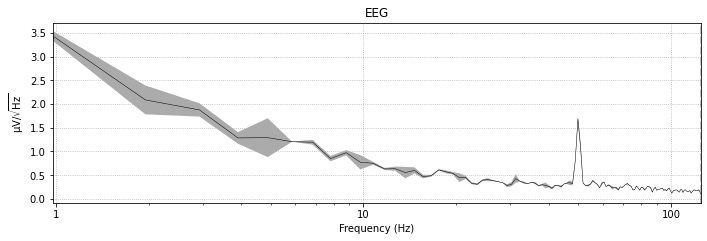

In [6]:
raw.plot_psd(tmax=10., average=True, spatial_colors=False,
                 dB=False, xscale='log')

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
Using matplotlib as 2D backend.


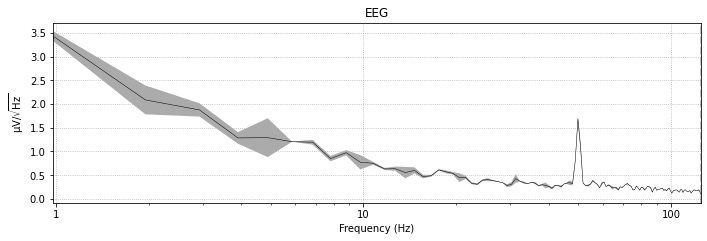

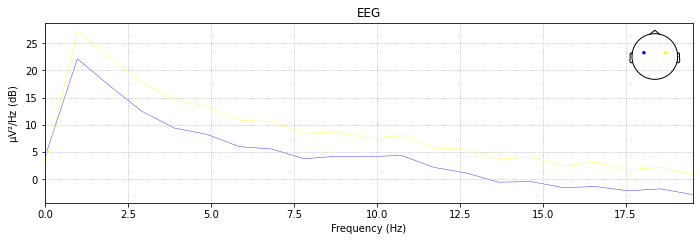

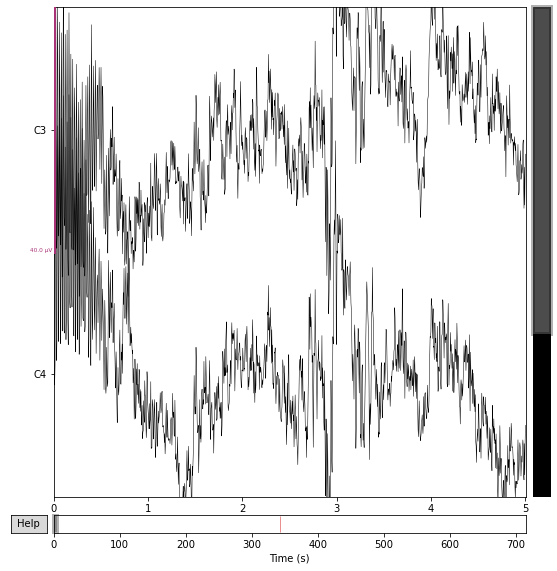

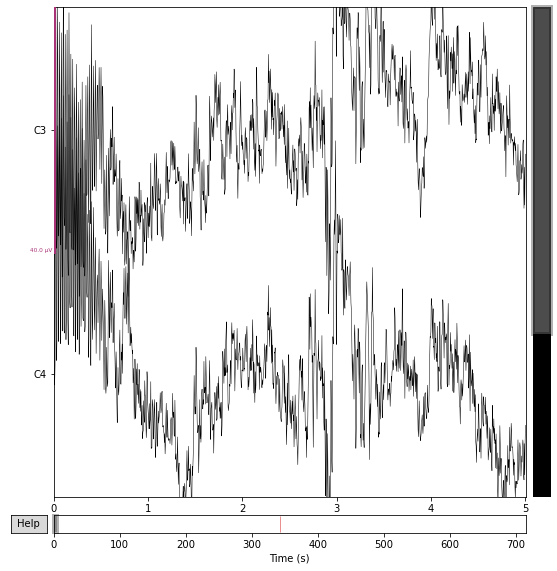

In [7]:
raw.plot_psd(fmax=20)
raw.plot(duration=5, n_channels=2)

In [8]:
l_vis_T1=epochs["1"].average()
l_vis_T2=epochs["2"].average()

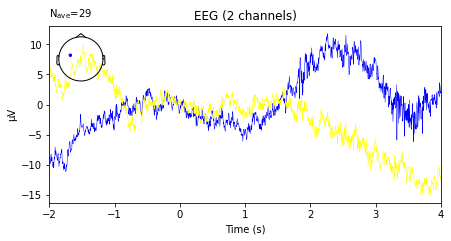

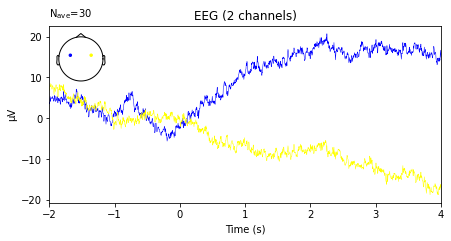

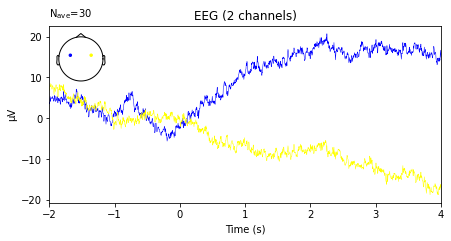

In [9]:
l_vis_T1.plot()
l_vis_T2.plot() 


In [10]:
epochs

Number of events,59
Events,1: 292: 303: 0
Time range,-2.000 – 4.000 sec
Baseline,-1.000 – 0.000 sec


In [11]:

freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -2, 4
event_ids = epochs.event_id

In [12]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=1)
tfr=tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
target=tfr.events[:, -1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


In [13]:
df = tfr[1].to_data_frame(time_format=None)
#tfr[1].crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df=df[df.time > 0]
#df.head()
df

,time,freq,epoch,condition,C3,C4
501,0.004,8.0,4,1,-0.679501,0.193914
502,0.008,8.0,4,1,-0.664908,0.171774
503,0.012,8.0,4,1,-0.659227,0.124250
504,0.016,8.0,4,1,-0.651684,0.103860
505,0.020,8.0,4,1,-0.643322,0.088943
...,...,...,...,...,...,...
9001,3.984,13.0,4,1,-0.616459,-0.856023
9002,3.988,13.0,4,1,-0.600655,-0.848615
9003,3.992,13.0,4,1,-0.531572,-0.845729
9004,3.996,13.0,4,1,-0.431728,-0.840956


In [14]:
df['C3>C4'] = df['C3'] > df["C4"]

df['C3>C4'].value_counts()


True     4418
False    1582
Name: C3>C4, dtype: int64

In [15]:
df.mean(axis = 0)

time          2.002000
freq         10.500000
epoch         4.000000
condition          inf
C3            2.894039
C4            0.885993
C3>C4         0.736333
dtype: float64

In [16]:
result=[]
for i in range(epochs.events.shape[0]):
    df = tfr[i].to_data_frame(time_format=None)
    df=df[df.time > 0]
    mean_C3=df["C3"].mean(axis = 0)
    mean_C4=df["C4"].mean(axis = 0)
    if mean_C3 > mean_C4 :
        result.append(1)
    if mean_C3 < mean_C4 :
        result.append(2)

In [17]:
count_true = 0
count_false = 0 
for i in range(target.shape[0]):
    if result[i] == target[i]:
        count_true +=1
    if result[i] != target[i] :
        count_false +=1
    acc_true = (count_true/target.shape[0])*100
    acc_false = (count_false/target.shape[0])*100
print("acc_true : {} %".format(acc_true))
print("acc_false : {} %".format(acc_false))

acc_true : 50.847457627118644 %
acc_false : 49.152542372881356 %


### 

In [18]:
#tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),ordered=True)
df

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value,band
0,2,2,8.0,-2.000,C3,eeg,-0.418738,alpha
1,2,2,8.0,-2.000,C4,eeg,-0.071583,alpha
2,2,2,8.0,-1.996,C3,eeg,-0.414549,alpha
3,2,2,8.0,-1.996,C4,eeg,-0.072073,alpha
4,2,2,8.0,-1.992,C3,eeg,-0.416331,alpha
...,...,...,...,...,...,...,...,...
1062703,2,118,13.0,3.992,C4,eeg,1.888352,alpha
1062704,2,118,13.0,3.996,C3,eeg,7.708178,alpha
1062705,2,118,13.0,3.996,C4,eeg,1.667620,alpha
1062706,2,118,13.0,4.000,C3,eeg,7.135608,alpha


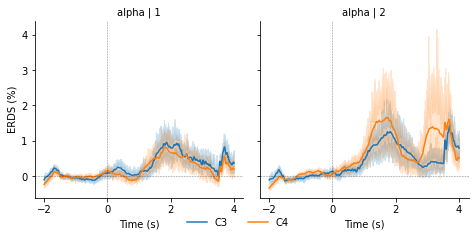

In [19]:
g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, None))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
g.fig